## Problem Statement

- Backorders are unavoidable, but by anticipating which things will be backordered, planning can be streamlined at several levels, preventing unexpected strain on production, logistics, and transportation.
- Material backorder is a common supply chain problem, impacting an inventory system service level and effectiveness. `Identifying parts with the highest chances of shortage prior its occurrence can present a high opportunity to improve an overall company’s performance.` 
- ERP systems generate a lot of data (mainly structured) and also contain a lot of historical data; if this data can be properly utilized, a predictive model to forecast backorders and plan accordingly can be constructed.
- Based on past data from inventories, supply chain, and sales, classify the products as
going into backorder (Yes or No).
- The Problem is to prevent the unexpected strain on production,logistcs and transportation.
- From then problem statement we need reduce the both False Positve and False Negative.
    - False Negative reduction will help us to prevent the unexpected strain on production,logistics and transportation
    - False positive is not that much important to the company because even if it is predicted as product is going to be backordered but actually is not backorded.
    - The macro-average is not recommended since it gives equal weight to both classes, which is not desirable when dealing with imbalanced data. The weighted average and micro-average metrics give more weight to the minority class, which is important when evaluating the classifier's performance on imbalanced data.

## Description about features in Dataset

- sku - Random ID for the product
- national_inv - Current inventory level for the part(different products).
- lead_time - Transit time for product. The time taken from release of an order to production and shipment(if available)
- in_transit_qty - Amount of product in transit from source(The total number of products that are currently being shipped from one location to another)
- forecast_3_month - Forecast sales for the next 3 months
- forecast_6_month - Forecast sales for the next 6 months
- forecast_9_month - Forecast sales for the next 9 months
- sales_1_month - Sales quantity for the prior 1 month time period
- sales_3_month - Sales quantity for the prior 3 month time period
- sales_6_month - Sales quantity for the prior 6 month time period
- sales_9_month - Sales quantity for the prior 9 month time period
- min_bank - Minimum recommend amount to stock
- potential_issue - Source issue for part identified (Potential damage)
- pieces_past_due - Parts overdue from source (Products overdue from source)
- perf_6_month_avg - Source performance for prior 6 month period
- perf_12_month_avg - Source performance for prior 12 month period
- local_bo_qty - Amount of stock orders overdue
- deck_risk - Part risk flag(The products that might remain in the deck/shop/stock)
- oe_constraint - Part risk flag(Products that are facing operational limiting factors such as bottleneck)
- ppap_risk - Part risk flag (Risks associated with packaging and production )
- stop_auto_buy - Part risk flag(Whether automatic selling process has been stopped or not)
- rev_stop - Part risk flag (Revenue status for product)
- went_on_backorder - Product actually went on backorder. This is the target value.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler,LabelEncoder,PowerTransformer,OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.ensemble import BalancedBaggingClassifier
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:

dataset:pd.DataFrame = pd.read_parquet('/config/workspace/sample_bo.parquet.gzip')

# Displaying top 5 rows

dataset.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
732013,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.98,0.98,0.0,No,No,Yes,Yes,No,No
38200,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,No,0.0,0.70,0.75,0.0,No,No,No,Yes,No,No
1145713,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No,0.0,0.92,0.96,0.0,Yes,No,Yes,Yes,No,No
1080013,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,No,0.0,0.62,0.62,0.0,Yes,No,No,Yes,No,No
1264726,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,No,No,No


In [3]:
dataset.reset_index(inplace=True,drop=True)

In [4]:
# Checking the shape of the dataset

dataset.shape

(500000, 22)

In [5]:
dataset.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.98,0.98,0.0,No,No,Yes,Yes,No,No
1,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,No,0.0,0.70,0.75,0.0,No,No,No,Yes,No,No
2,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No,0.0,0.92,0.96,0.0,Yes,No,Yes,Yes,No,No
3,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,No,0.0,0.62,0.62,0.0,Yes,No,No,Yes,No,No
4,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,No,No,No


In [6]:
# diplaying column names

dataset.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [7]:
# dataset information

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   national_inv       499999 non-null  float64
 1   lead_time          470155 non-null  float64
 2   in_transit_qty     499999 non-null  float64
 3   forecast_3_month   499999 non-null  float64
 4   forecast_6_month   499999 non-null  float64
 5   forecast_9_month   499999 non-null  float64
 6   sales_1_month      499999 non-null  float64
 7   sales_3_month      499999 non-null  float64
 8   sales_6_month      499999 non-null  float64
 9   sales_9_month      499999 non-null  float64
 10  min_bank           499999 non-null  float64
 11  potential_issue    499999 non-null  object 
 12  pieces_past_due    499999 non-null  float64
 13  perf_6_month_avg   499999 non-null  float64
 14  perf_12_month_avg  499999 non-null  float64
 15  local_bo_qty       499999 non-null  float64
 16  de

In [8]:
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtype !='O']
categorical_features = [feature for feature in dataset.columns if feature not in numerical_features]

print(f"Number of numerical features {len(numerical_features)}.\nNumerical features are \n {numerical_features}")
print(f"Number of Categorical features {len(categorical_features)}. \nCategorical features are \n {categorical_features}")

Number of numerical features 15.
Numerical features are 
 ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']
Number of Categorical features 7. 
Categorical features are 
 ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


In [9]:
# checking and dropping the duplicates

print("Number of duplicate values ",dataset.duplicated().sum())

# dropping duplicates

dataset.drop_duplicates(inplace=True)

# After dropping duplicates
print("After droppping Number of duplicate values ",dataset.duplicated().sum())

# After dropping duplicates the shape of the data
print('Shape of dataset ',dataset.shape)


Number of duplicate values  141544
After droppping Number of duplicate values  0
Shape of dataset  (358456, 22)


- As we can observe there are no duplicate values are there in the dataset.

In [10]:
# Checking for null values

dataset.isnull().sum()

national_inv             1
lead_time            15585
in_transit_qty           1
forecast_3_month         1
forecast_6_month         1
forecast_9_month         1
sales_1_month            1
sales_3_month            1
sales_6_month            1
sales_9_month            1
min_bank                 1
potential_issue          1
pieces_past_due          1
perf_6_month_avg         1
perf_12_month_avg        1
local_bo_qty             1
deck_risk                1
oe_constraint            1
ppap_risk                1
stop_auto_buy            1
rev_stop                 1
went_on_backorder        1
dtype: int64

In [11]:
# As we can observe there is one row with all null values

# we can drop the row with more than 10 null values

dataset.dropna(thresh=10,inplace=True)
dataset.isnull().sum()

national_inv             0
lead_time            15584
in_transit_qty           0
forecast_3_month         0
forecast_6_month         0
forecast_9_month         0
sales_1_month            0
sales_3_month            0
sales_6_month            0
sales_9_month            0
min_bank                 0
potential_issue          0
pieces_past_due          0
perf_6_month_avg         0
perf_12_month_avg        0
local_bo_qty             0
deck_risk                0
oe_constraint            0
ppap_risk                0
stop_auto_buy            0
rev_stop                 0
went_on_backorder        0
dtype: int64

In [12]:
dataset.shape

(358455, 22)

### Visualizing the null values

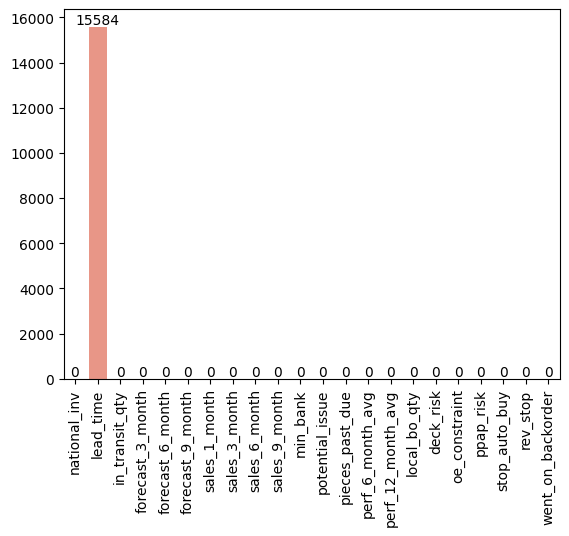

In [13]:
null_values = {feature:dataset[feature].isnull().sum() for feature in dataset.columns}
ax=sns.barplot(x=list(null_values.keys()),y=list(null_values.values()))
plt.title= "NUll value frequency"
plt.xlabel='Features'
plt.ylabel='Count'
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks(rotation=90)
plt.show()


### Observation
 - Only lead_time has high nan values.

### Describing the numerical and categorical features

In [14]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,358455.0,694.490748,43731.651679,-25414.0,7.00,28.00,129.00,12315072.0
lead_time,342871.0,7.750026,7.350620,0.0,4.00,8.00,8.00,52.0
in_transit_qty,358455.0,63.709085,1665.970105,0.0,0.00,0.00,1.00,288768.0
forecast_3_month,358455.0,266.767279,7184.801169,0.0,0.00,0.00,16.00,1427612.0
forecast_6_month,358455.0,513.741959,13715.783423,0.0,0.00,0.00,40.00,2446072.0
forecast_9_month,358455.0,750.857712,19940.767869,0.0,0.00,1.00,64.00,3760840.0
sales_1_month,358455.0,82.981705,2625.283707,0.0,0.00,1.00,10.00,741774.0
sales_3_month,358455.0,260.113297,7220.660989,0.0,0.00,5.00,35.00,1104181.0
sales_6_month,358455.0,505.131381,13338.393211,0.0,1.00,10.00,71.00,2145715.0
sales_9_month,358455.0,774.354828,20420.053731,0.0,2.00,15.00,108.00,3204929.0


### Observation

1. For some of the products the inventory level is negative means there may be a chance that negative inventory products can go backorder(Assumption).
2. 75% of the prodcuts delivered in lead_time 0-8 weeks.
3. There are 288768.0 are being transfered from one place to another.
4. The min_back for 75% of the products are 0-15.
5. The max value for peformance variable is 1. May be the products that are not in production or currently deprecated may be replace with -99.(Assumption)

In [28]:
dataset.describe(include='O')

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,358455,358455,358455,358455,358455,358455,358455
unique,2,2,2,2,2,2,2
top,No,No,No,No,Yes,No,No
freq,358184,287841,358386,313236,344061,358319,355159


### Observation
1. There is no potential is issue for many products
2. Most of the prodcuts there is not risk associated with them
3. The most products stop_auto_buy is yes.
4. Nearly 70-80% of the products doesn't remain in shop.
5. For the maximum products the revenue is being generated.
6. The maximum products doesn't went on backorder.

`We can cleary observe that there is huge class imbalance in target variable as well independent categorical variables`

### Visualizing the Numerical features

<Figure size 1500x10000 with 0 Axes>

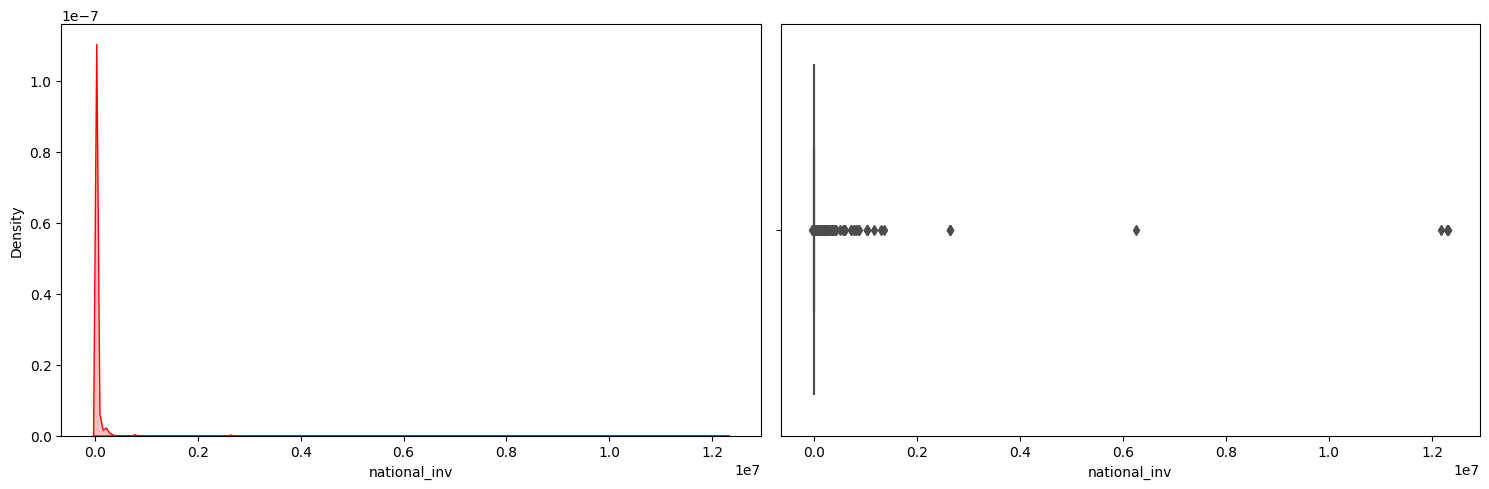

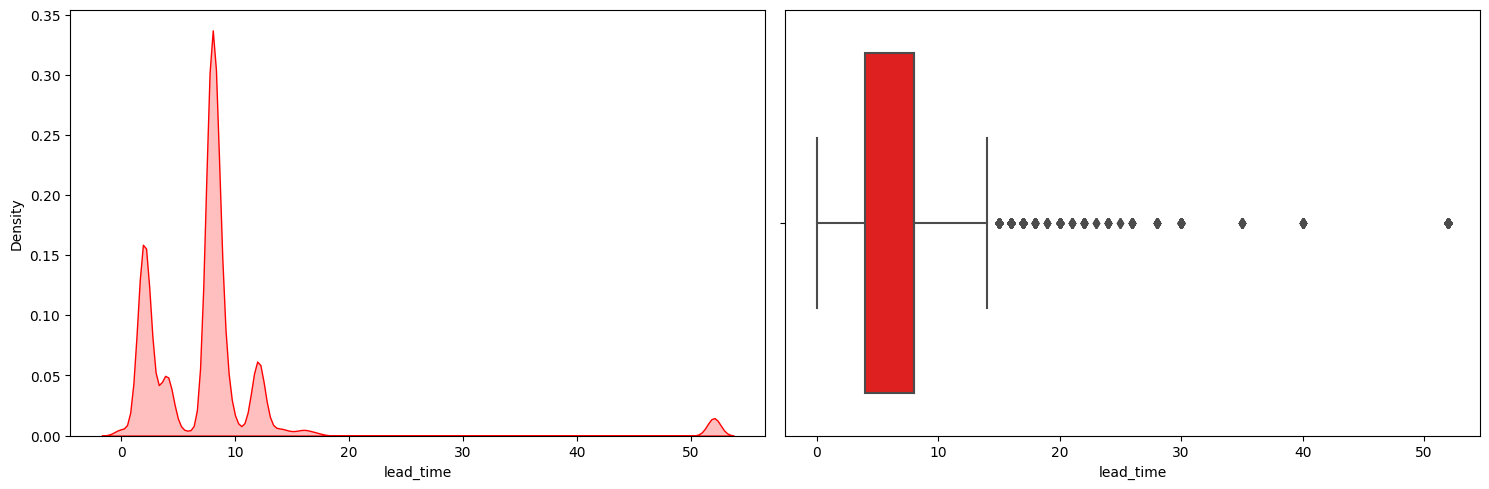

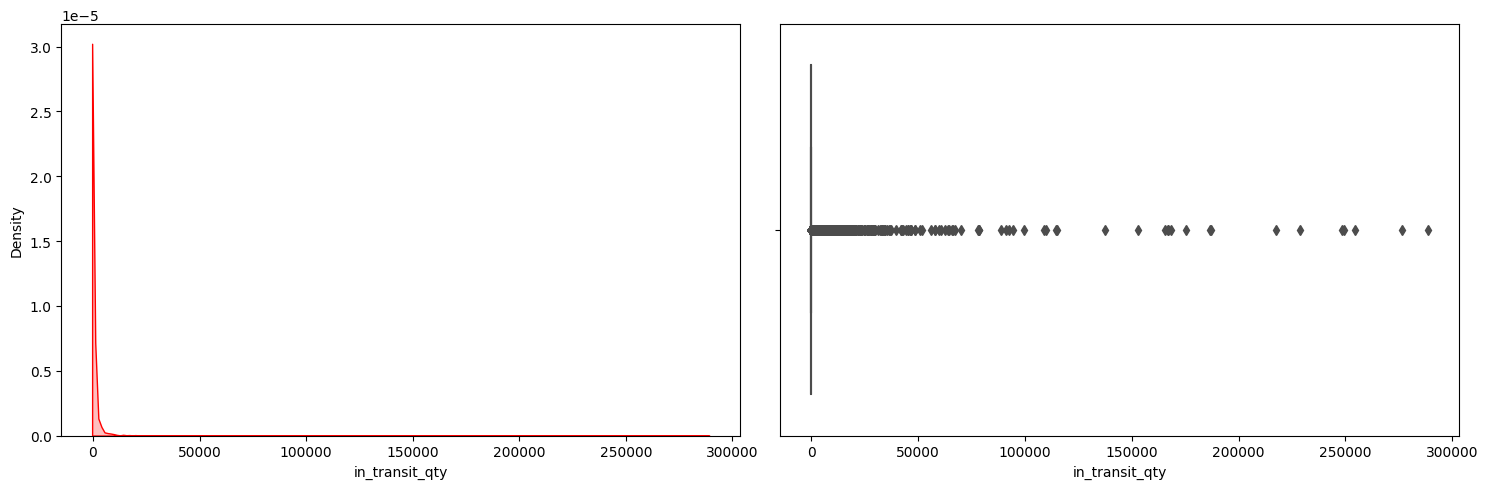

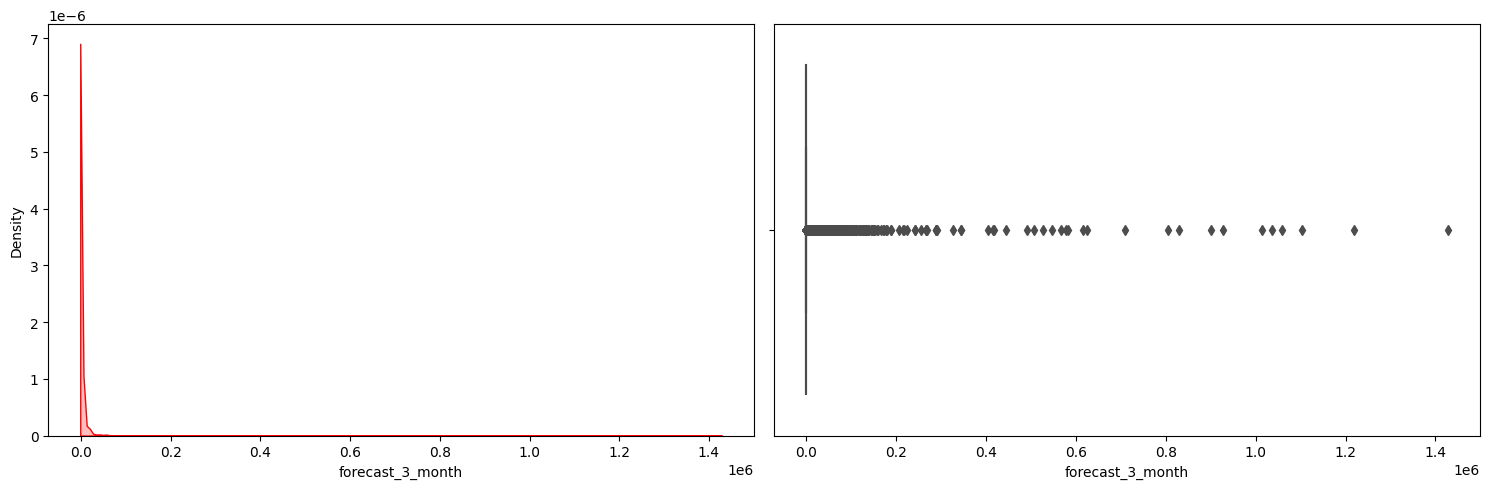

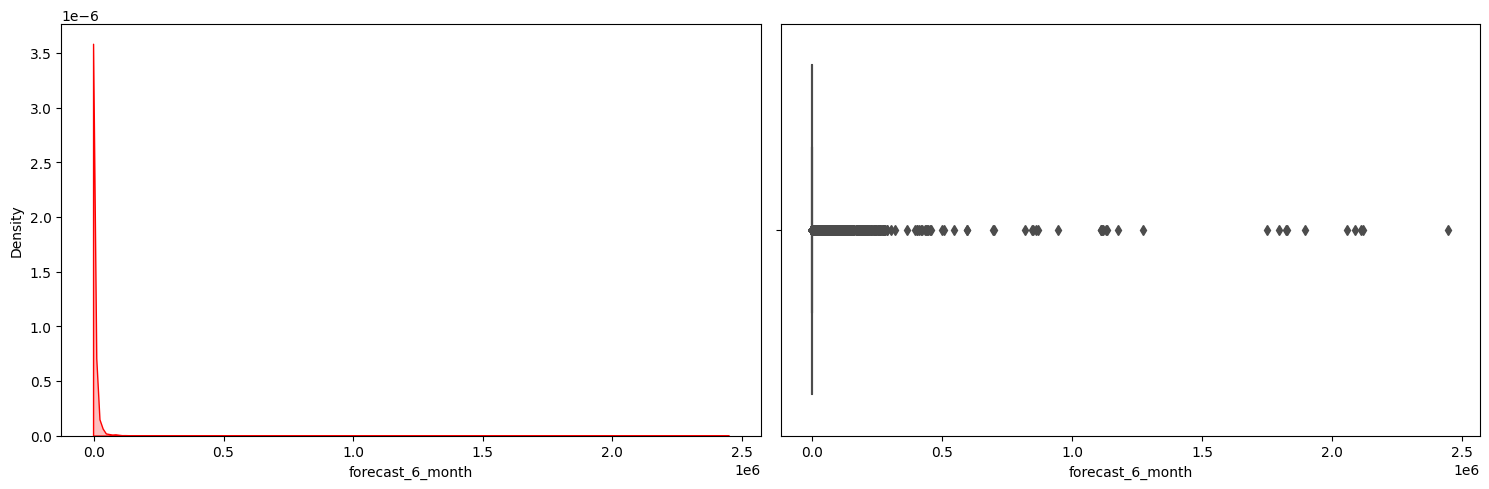

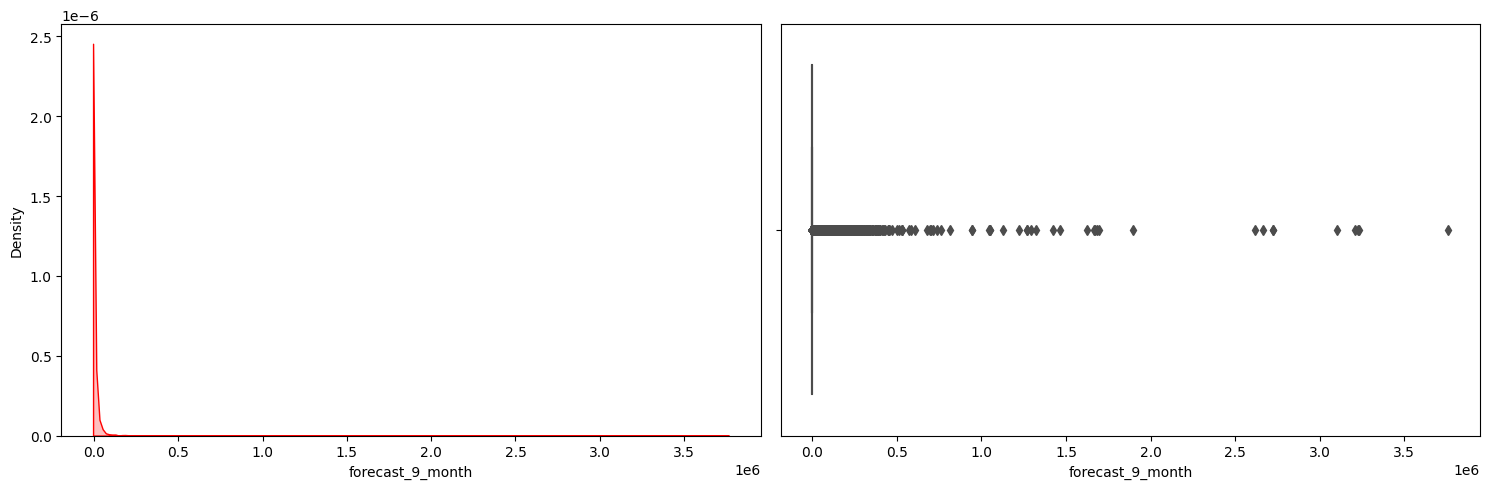

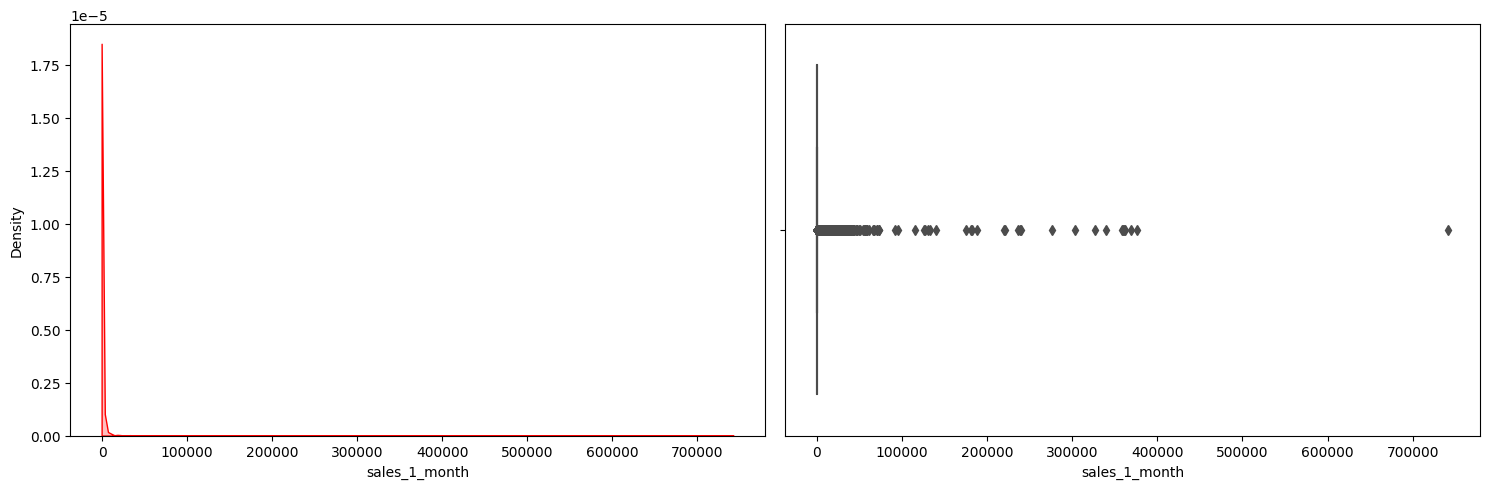

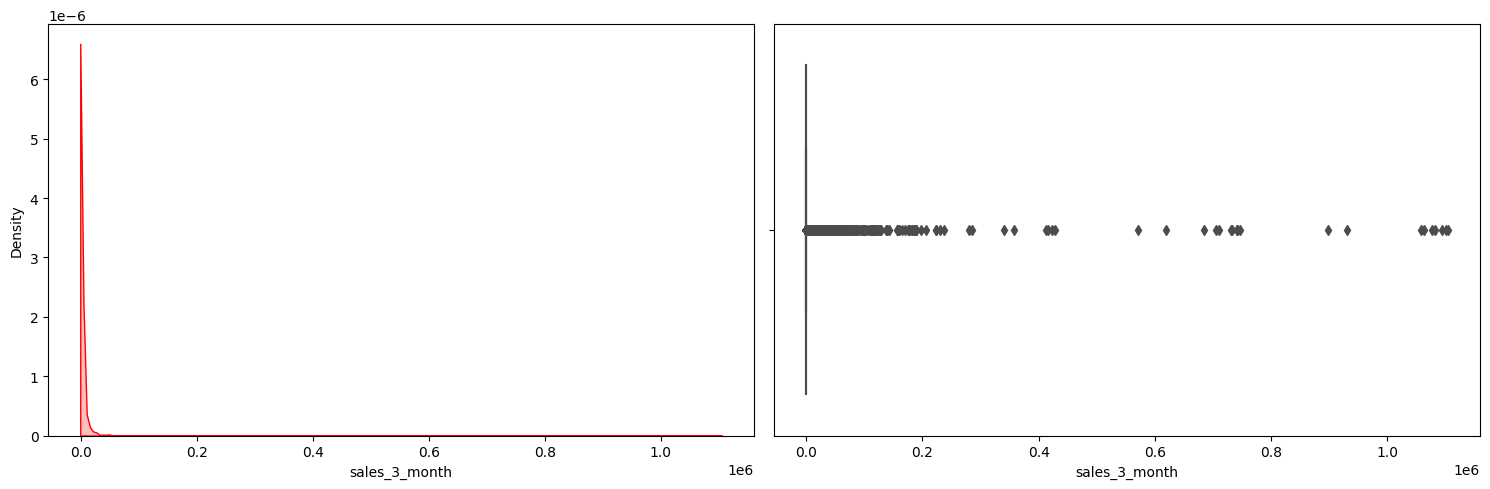

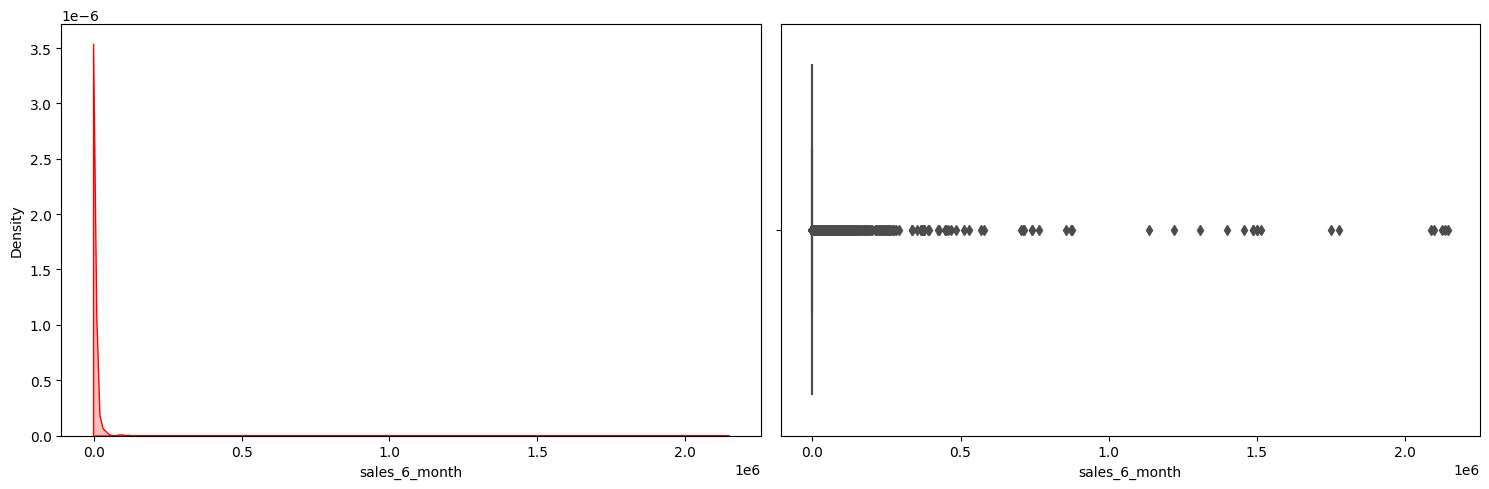

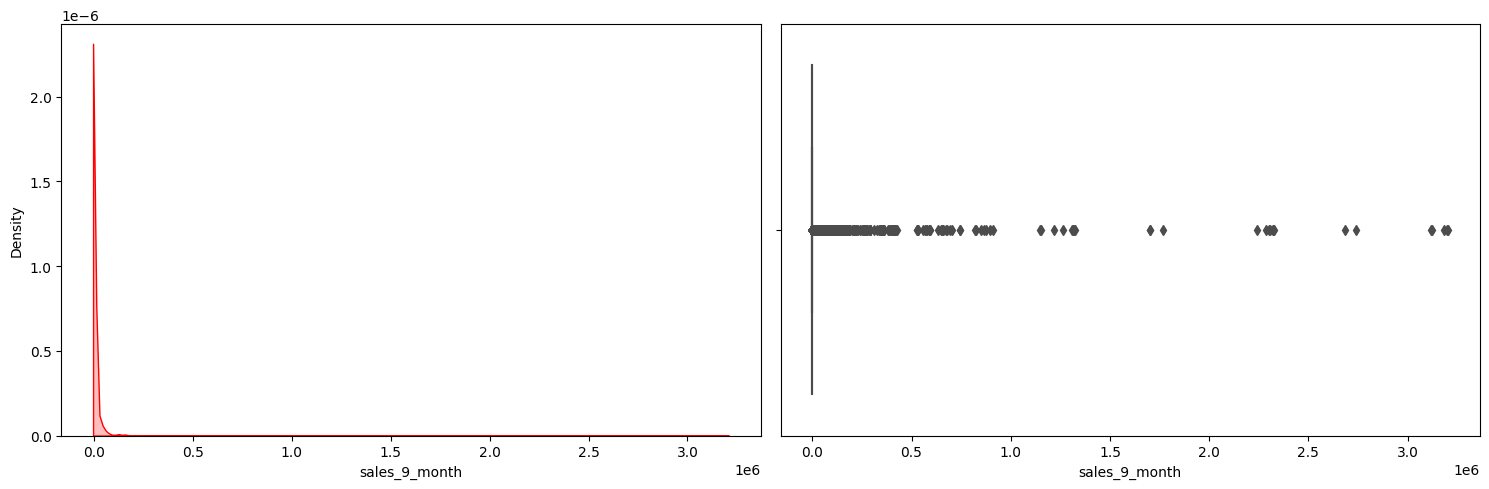

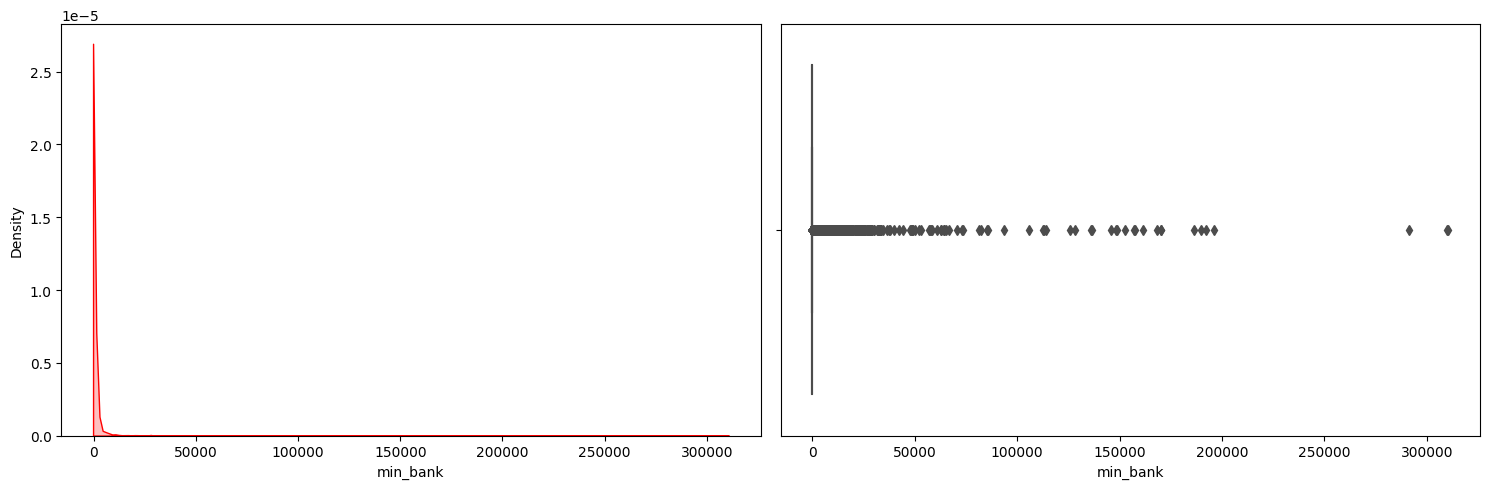

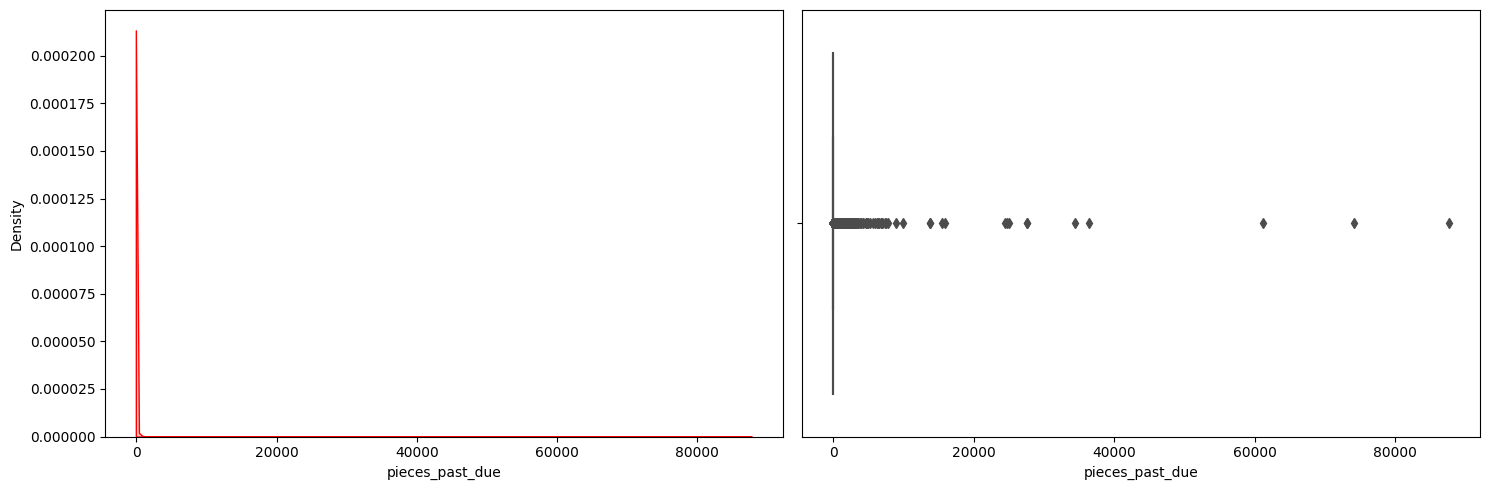

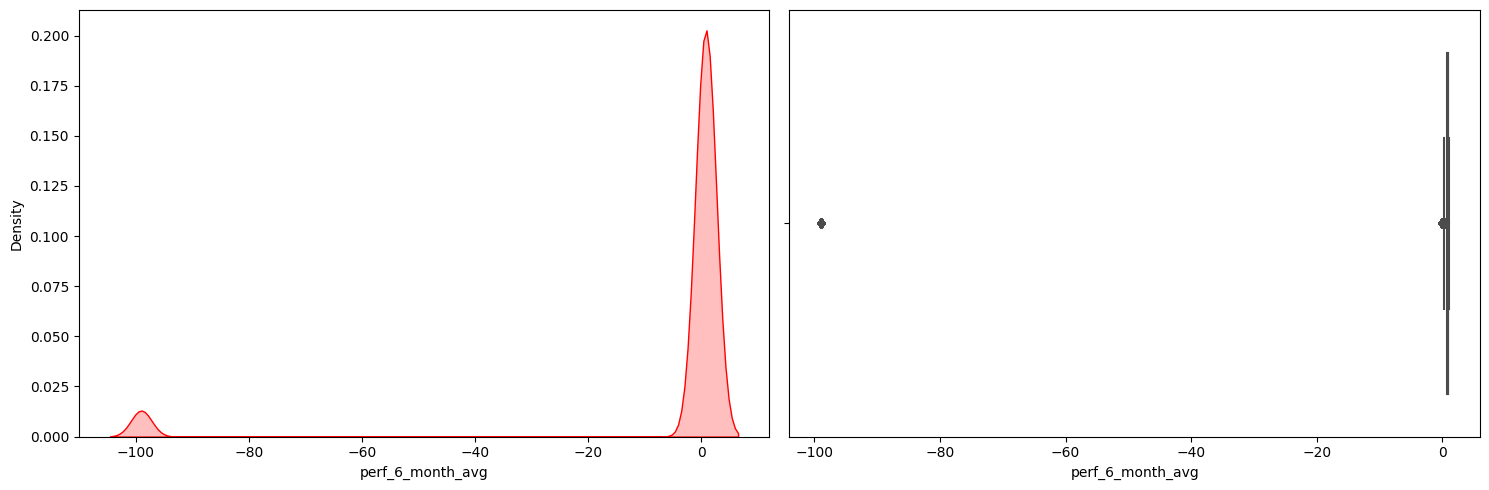

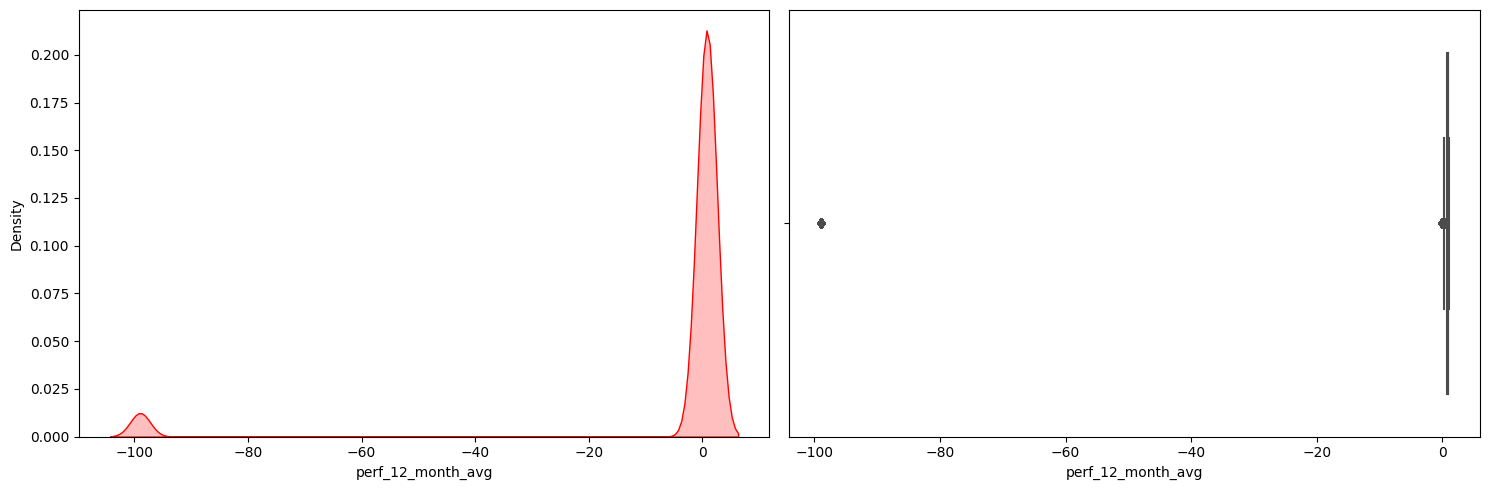

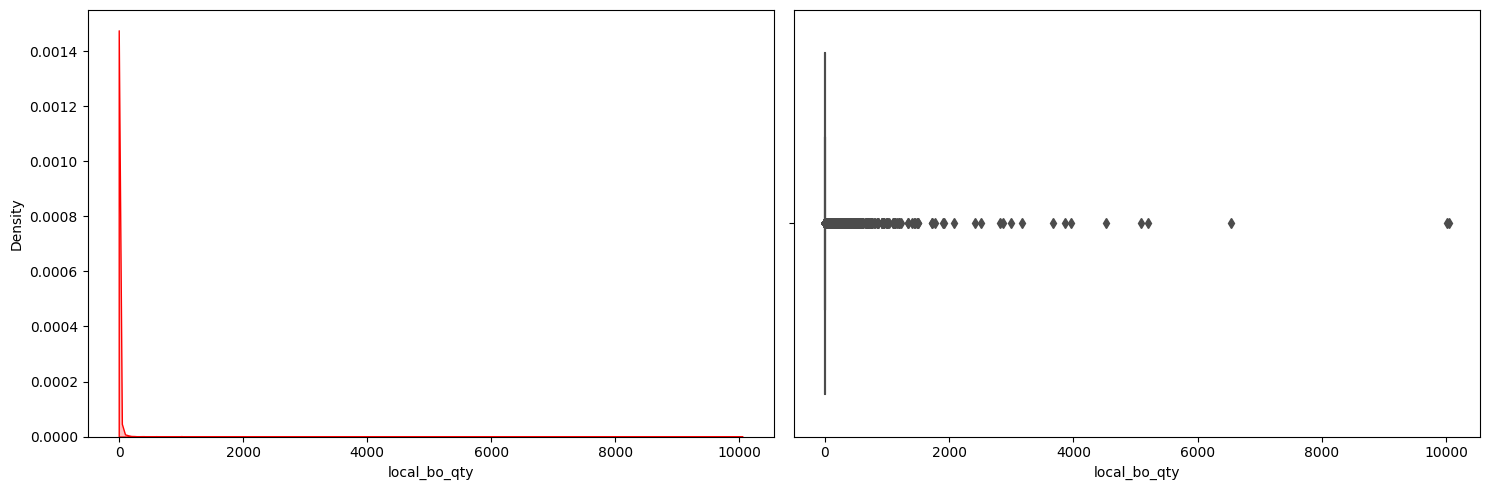

In [24]:

plt.figure(figsize=(15, 100))
for i, feature in enumerate(numerical_features):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.kdeplot(x=dataset[feature], color='r',shade=True,ax=axes[0])
    plt.xlabel=numerical_features[i]
    plt.ylabel='Density'
    sns.boxplot(x=dataset[feature], color='r',ax=axes[1])
    plt.xlabel=numerical_features[i]
    plt.ylabel='Density'
    plt.tight_layout()


### Observation

1. We can observe that all the feature highly right skewed except performance variables that are left skewed.
2. We can observe that in performance variables some of the values are `-99` may be the nan values replace with -99 or those products are not in production and selling process
3. The lead_time for the most products are between 0 - 25.
4. The sales performance variables are almost right skewed.

### Visualizing categorical variabels with hue as 'went_on_backorder'


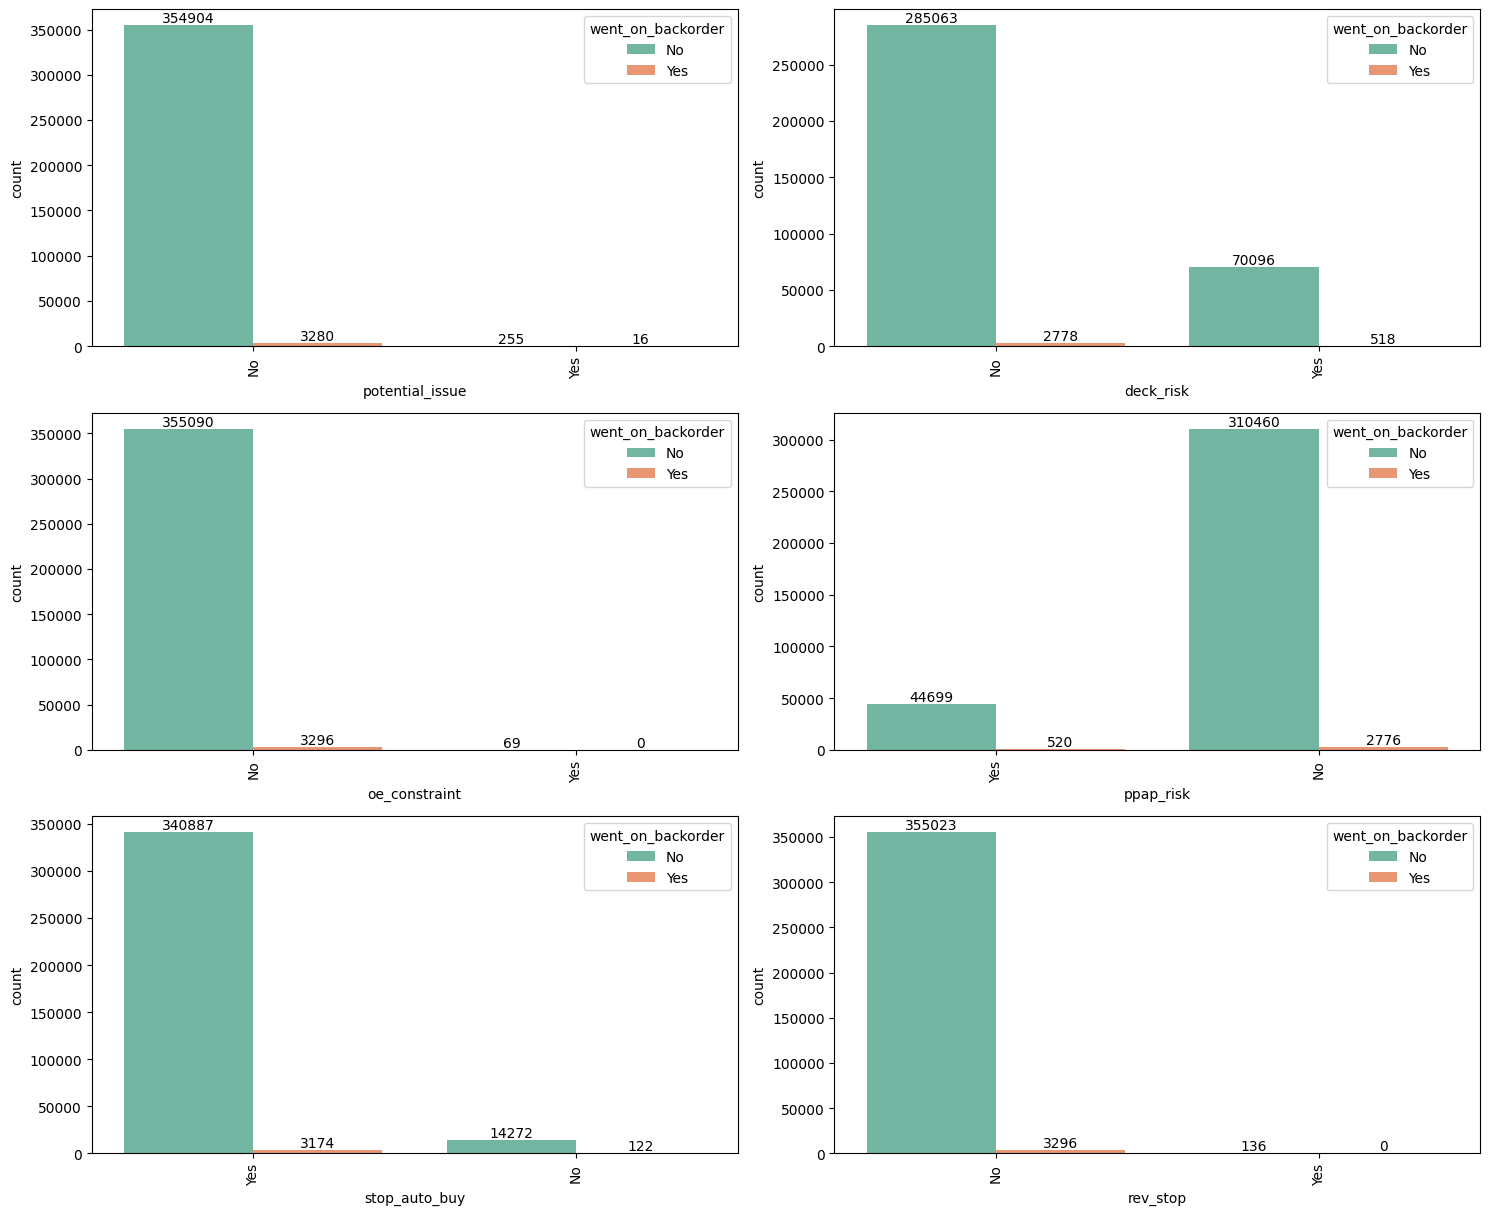

In [32]:
plt.figure(figsize=(15,40))
for i, feature in enumerate(categorical_features[:-1]):
    plt.subplot(10, 2, i+1)
    ax=sns.countplot(x=dataset[feature],palette='Set2',hue=dataset['went_on_backorder'])
    plt.xlabel = feature
    plt.ylabel = 'Frequency'
    plt.xticks(rotation=90)
    for i in ax.containers:
        ax.bar_label(i)
    plt.tight_layout()

### Observation

1. `99%` of the products doesn't went on backorder if potential issue is flagged as `No`.
2. Nearly `80%` of the products doesn't went on backorder if deck_risk is flagged as `No`.
3. If the product doesn't face on any operational risk (oe_constraint) `99%` of the products doesn't went on back order.
4. `86%` of the products doesn't went on backorder when there is no packaging risk.
5. `95%` of the products stop auto buy has been stopped.

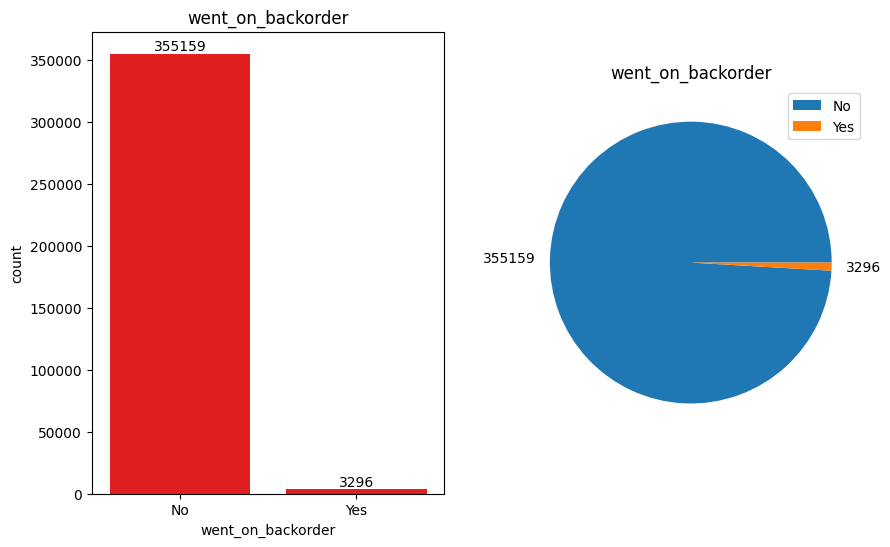

In [39]:
fig, ax = plt.subplots(1,2,figsize=(10,6))

# ploting barplot for target feature

sns.countplot(x=dataset['went_on_backorder'],ax=ax[0],color='r')
ax[0].set_title('went_on_backorder')
for i in ax[0].containers:
    ax[0].bar_label(i,)

# plotting piechart for target feature
values = dataset['went_on_backorder'].value_counts()
ax[1].pie(values,labels=values)
ax[1].set_title('went_on_backorder')
ax[1].legend(values.keys().tolist())

plt.show()


### Observation
1. The target classes are **highly imbalanced**
2. Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
3. If the imbalanced data is not treated, then this will degrade the performance of the classifier model. Hence we should handle imbalanced data with certain methods.

### HeatMap

<Axes: >

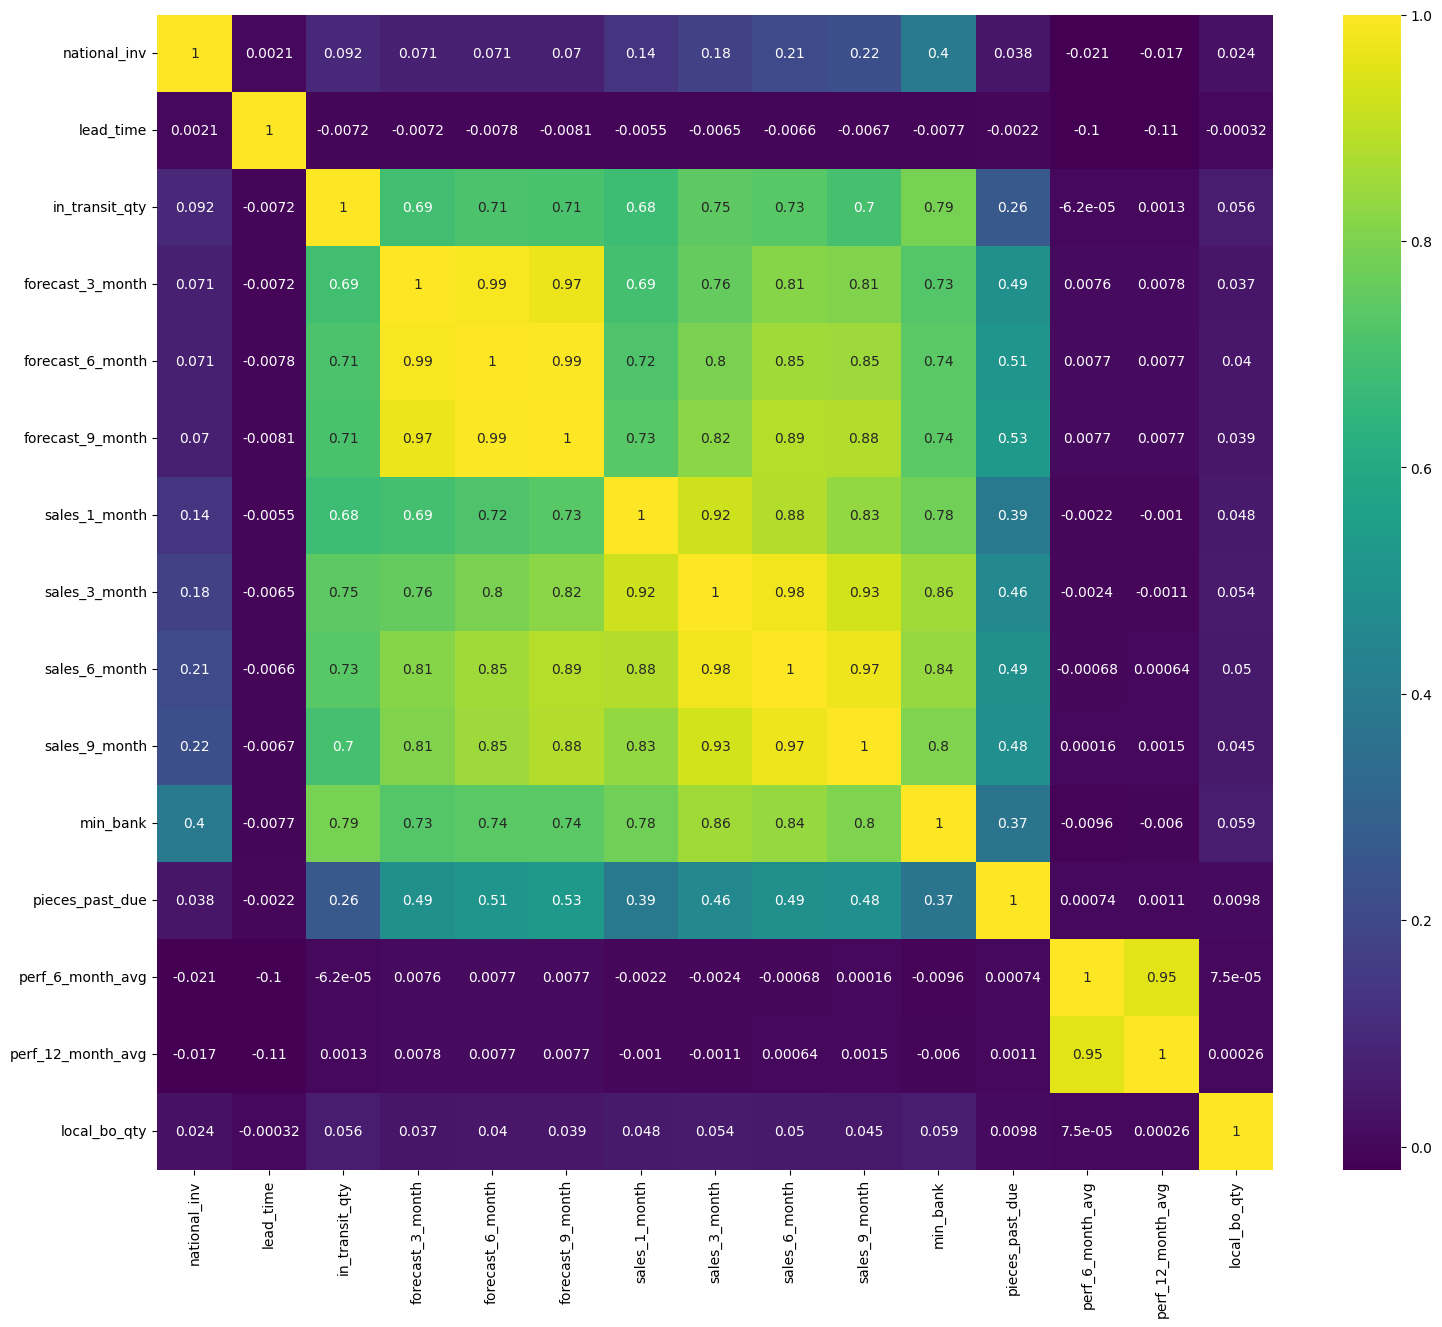

In [44]:
plt.figure(figsize=(18, 15))
sns.heatmap(dataset[numerical_features].corr(),annot=True,cmap='viridis',robust=True)

### Observation

1. Sales variables are highly correlated with each other.
2. Forecast variables are also highly correlated with other.
3. Nearly sales and forecast variables are 80% correlated with each other.

### Observation

**For Scaling**
1. We can try RobustScaling as there are outliers in the dataset and power transformer{yeo-jhonson} as there are negative values in the dataset.

**Handling Imbalance Data**
1. We can try OverSampling(Smote).

**Models**
1. For our baseline model we can select logistic regression.
2. And We can choose ensemble techniques as there are outliers in our data.
RandomForestClassifier
ExtraTreeClassifier
GradientBoostingClassifier

##  Model Building

In [13]:
## Copying the dataset
df = dataset.copy()

### Encoding categorical variables

- All categorical varibles are binary variables so we can use onehotencoder and drop a first or last column.
- For Output variable we can use labelEncoder.

In [14]:
ohe = OneHotEncoder(sparse=False,drop='if_binary')
df[categorical_features[:-1]] = ohe.fit_transform(df[categorical_features[:-1]])

In [15]:
label_encoder = LabelEncoder()
df[categorical_features[-1]] = label_encoder.fit_transform(df[categorical_features[-1]])

In [19]:
## using robust scaling and base model

X,y = df.drop('went_on_backorder',axis=1),df.went_on_backorder
median_robust_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
    ])
X[numerical_features] = median_robust_pipeline.fit_transform(X[numerical_features])

X,y = SMOTE(random_state=42,sampling_strategy='minority',k_neighbors=99).fit_resample(X,y)


In [21]:
## Logistic Regression
skf = StratifiedKFold(n_splits=3)
log1=[]
i=1
for train_idx,test_idx in skf.split(X,y):
    X1_train , X1_test = X.iloc[train_idx] , X.iloc[test_idx]
    y1_train , y1_test = y.iloc[train_idx] , y.iloc[test_idx]
    log = LogisticRegression()
    log.fit(X1_train,y1_train)
    train_pred = log.predict(X1_train)
    print(f"{i} iteration train score {f1_score(y1_train,train_pred)}")
    test_pred = log.predict(X1_test)
    print(f"{i} iteration test score {f1_score(y1_test,test_pred)}")
    print(f"---  Classification Report of {i} testing ----")
    print(classification_report(y1_test,test_pred))
    print(f" --- Confusion Matrix of {i} testing----")
    print(confusion_matrix(y1_test,test_pred))
    print("----------------------------------------------------------------------")
    log1.append(log)
    i+=1

1 iteration train score 0.7765682225240292
1 iteration test score 0.7672170274996465
---  Classification Report of 1 testing ----
              precision    recall  f1-score   support

           0       0.89      0.49      0.63    118387
           1       0.65      0.94      0.77    118386

    accuracy                           0.71    236773
   macro avg       0.77      0.71      0.70    236773
weighted avg       0.77      0.71      0.70    236773

 --- Confusion Matrix of 1 testing----
[[ 58062  60325]
 [  7166 111220]]
----------------------------------------------------------------------
2 iteration train score 0.7768152026139411
2 iteration test score 0.7789512403884923
---  Classification Report of 2 testing ----
              precision    recall  f1-score   support

           0       0.89      0.54      0.67    118386
           1       0.67      0.93      0.78    118387

    accuracy                           0.74    236773
   macro avg       0.78      0.74      0.73    236

## Observation 
- On performing median imputation and robust Scaling the LogisticRegression Model gave average 75% accuracy on  both train and test data

In [24]:
### Using Robust Scaling and Random Forest classifier
skf = StratifiedKFold(n_splits=3)
rf1=[]
i=1
for train_idx,test_idx in skf.split(X,y):
    X1_train , X1_test = X.iloc[train_idx] , X.iloc[test_idx]
    y1_train , y1_test = y.iloc[train_idx] , y.iloc[test_idx]

    clf = RandomForestClassifier()
    clf.fit(X1_train,y1_train)
    train_pred = clf.predict(X1_train)
    print(f"{i} iteration train score {f1_score(y1_train,train_pred)}")
    test_pred = clf.predict(X1_test)
    print(f"{i} iteration test score {f1_score(y1_test,test_pred)}")
    print(f"---  Classification Report of {i} testing ----")
    print(classification_report(y1_test,test_pred))
    print(f" --- Confusion Matrix of {i} testing----")
    print(confusion_matrix(y1_test,test_pred))
    print("----------------------------------------------------------------------")
    rf1.append(clf)
    i+=1

1 iteration train score 1.0
1 iteration test score 0.9879104092349749
---  Classification Report of 1 testing ----
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    118387
           1       0.99      0.99      0.99    118386

    accuracy                           0.99    236773
   macro avg       0.99      0.99      0.99    236773
weighted avg       0.99      0.99      0.99    236773

 --- Confusion Matrix of 1 testing----
[[117185   1202]
 [  1655 116731]]
----------------------------------------------------------------------
2 iteration train score 0.9998057005761399
2 iteration test score 0.9904975128565535
---  Classification Report of 2 testing ----
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    118386
           1       0.99      0.99      0.99    118387

    accuracy                           0.99    236773
   macro avg       0.99      0.99      0.99    236773
weighted av

In [19]:
### Using Robust Scaling and GradientBoostingClassifier

skf = StratifiedKFold(n_splits=3)
gb1=[]
i=1
for train_idx,test_idx in skf.split(X,y):
    X1_train , X1_test = X.iloc[train_idx] , X.iloc[test_idx]
    y1_train , y1_test = y.iloc[train_idx] , y.iloc[test_idx]

    clf = GradientBoostingClassifier()
    clf.fit(X1_train,y1_train)
    train_pred = clf.predict(X1_train)
    print(f"{i} iteration train score {f1_score(y1_train,train_pred)}")
    test_pred = clf.predict(X1_test)
    print(f"{i} iteration test score {f1_score(y1_test,test_pred)}")
    print(f"---  Classification Report of {i} testing ---")
    print(classification_report(y1_test,test_pred))
    print(f" --- Confusion Matrix of {i} testing----")
    print(confusion_matrix(y1_test,test_pred))
    print("----------------------------------------------------------------------")
    gb1.append(clf)
    i+=1

1 iteration train score 0.9235535509013643
1 iteration test score 0.9218755881602556
---  Classification Report of 1 testing ---
              precision    recall  f1-score   support

           0       0.93      0.91      0.92    118370
           1       0.91      0.93      0.92    118369

    accuracy                           0.92    236739
   macro avg       0.92      0.92      0.92    236739
weighted avg       0.92      0.92      0.92    236739

 --- Confusion Matrix of {1} testing----
[[107853  10517]
 [  8162 110207]]
----------------------------------------------------------------------
2 iteration train score 0.9226661771944901
2 iteration test score 0.9220353971226802
---  Classification Report of 1 testing ---
              precision    recall  f1-score   support

           0       0.93      0.91      0.92    118369
           1       0.91      0.93      0.92    118370

    accuracy                           0.92    236739
   macro avg       0.92      0.92      0.92    236

In [16]:
### Using yeo-jhonson scaling 
X,y = df.drop('went_on_backorder',axis=1),df.went_on_backorder
median_robust_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('Power', PowerTransformer())
    ])
X[numerical_features] = median_robust_pipeline.fit_transform(X[numerical_features])

X,y = SMOTE(random_state=42,sampling_strategy='minority',k_neighbors=99).fit_resample(X,y)

In [26]:
skf = StratifiedKFold(n_splits=3)
log2=[]
i=1
for train_idx,test_idx in skf.split(X,y):
    X1_train , X1_test = X.iloc[train_idx] , X.iloc[test_idx]
    y1_train , y1_test = y.iloc[train_idx] , y.iloc[test_idx]
    log = LogisticRegression()
    log.fit(X1_train,y1_train)
    train_pred = log.predict(X1_train)
    print(f"{i} iteration train score {f1_score(y1_train,train_pred)}")
    test_pred = log.predict(X1_test)
    print(f"{i} iteration test score {f1_score(y1_test,test_pred)}")
    print(f"---  Classification Report of {i} testing ----")
    print(classification_report(y1_test,test_pred))
    print(f" --- Confusion Matrix of {i} testing----")
    print(confusion_matrix(y1_test,test_pred))
    print("----------------------------------------------------------------------")
    log2.append(log)
    i+=1

1 iteration train score 0.821654580857421
1 iteration test score 0.8253872978970728
---  Classification Report of 1 testing ----
              precision    recall  f1-score   support

           0       0.82      0.83      0.83    118387
           1       0.83      0.82      0.83    118386

    accuracy                           0.83    236773
   macro avg       0.83      0.83      0.83    236773
weighted avg       0.83      0.83      0.83    236773

 --- Confusion Matrix of 1 testing----
[[97831 20556]
 [20753 97633]]
----------------------------------------------------------------------
2 iteration train score 0.8224566542716507
2 iteration test score 0.8223828535406598
---  Classification Report of 2 testing ----
              precision    recall  f1-score   support

           0       0.82      0.82      0.82    118386
           1       0.82      0.83      0.82    118387

    accuracy                           0.82    236773
   macro avg       0.82      0.82      0.82    236773
w

In [19]:
### Using yeo-jhonson scaling and GradientBoostingClassifier

skf = StratifiedKFold(n_splits=3)
gb3=[]
i=1
for train_idx,test_idx in skf.split(X,y):
    X1_train , X1_test = X.iloc[train_idx] , X.iloc[test_idx]
    y1_train , y1_test = y.iloc[train_idx] , y.iloc[test_idx]

    clf = GradientBoostingClassifier(n_estimators=100,max_depth=9,min_samples_leaf=5)
    clf.fit(X1_train,y1_train)
    train_pred = clf.predict(X1_train)
    print(f"{i} iteration train score {f1_score(y1_train,train_pred)}")
    test_pred = clf.predict(X1_test)
    print(f"{i} iteration test score {f1_score(y1_test,test_pred)}")
    print(f"---  Classification Report of {i} testing ---")
    print(classification_report(y1_test,test_pred))
    print(f" --- Confusion Matrix of {i} testing----")
    print(confusion_matrix(y1_test,test_pred))
    print("----------------------------------------------------------------------")
    gb3.append(clf)
    i+=1

1 iteration train score 0.9898592719574143
1 iteration test score 0.9811818998645906
---  Classification Report of 1 testing ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    118370
           1       0.98      0.98      0.98    118369

    accuracy                           0.98    236739
   macro avg       0.98      0.98      0.98    236739
weighted avg       0.98      0.98      0.98    236739

 --- Confusion Matrix of 1 testing----
[[115979   2391]
 [  2070 116299]]
----------------------------------------------------------------------
2 iteration train score 0.9871552304069964
2 iteration test score 0.9867916310702382
---  Classification Report of 2 testing ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    118369
           1       0.98      1.00      0.99    118370

    accuracy                           0.99    236739
   macro avg       0.99      0.99      0.99    23673

In [19]:
skf = StratifiedKFold(n_splits=3)
rf4=[]
i=1
for train_idx,test_idx in skf.split(X,y):
    X1_train , X1_test = X.iloc[train_idx] , X.iloc[test_idx]
    y1_train , y1_test = y.iloc[train_idx] , y.iloc[test_idx]
    clf = RandomForestClassifier(n_estimators=100,max_depth=9,min_samples_leaf=5,bootstrap=True,oob_score=True)
    clf.fit(X1_train,y1_train)
    train_pred = clf.predict(X1_train)
    print(f"{i} iteration train score {f1_score(y1_train,train_pred)}")
    test_pred = clf.predict(X1_test)
    print(f"{i} iteration test score {f1_score(y1_test,test_pred)}")
    print(f"--- Classification Report of {i}testing ----")
    print(classification_report(y1_test,test_pred))
    print(f" --- Confusion Matrix of {i} testing----")
    print(confusion_matrix(y1_test,test_pred))
    print("----------------------------------------------------------------------")
    rf4.append(clf)
    i+=1

1 iteration train score 0.9195262022917795
1 iteration test score 0.9187672037212091
--- Classification Report of 1testing ----
              precision    recall  f1-score   support

           0       0.93      0.90      0.92    118370
           1       0.91      0.93      0.92    118369

    accuracy                           0.92    236739
   macro avg       0.92      0.92      0.92    236739
weighted avg       0.92      0.92      0.92    236739

 --- Confusion Matrix of 1 testing----
[[106917  11453]
 [  8054 110315]]
----------------------------------------------------------------------
2 iteration train score 0.9159473061044214
2 iteration test score 0.9148081256627784
--- Classification Report of 2testing ----
              precision    recall  f1-score   support

           0       0.93      0.89      0.91    118369
           1       0.90      0.93      0.91    118370

    accuracy                           0.91    236739
   macro avg       0.91      0.91      0.91    236739


In [22]:
from imblearn.ensemble import BalancedBaggingClassifier
skf = StratifiedKFold(n_splits=3)
ext1=[]
i=1
for train_idx,test_idx in skf.split(X,y):
    X1_train , X1_test = X.iloc[train_idx] , X.iloc[test_idx]
    y1_train , y1_test = y.iloc[train_idx] , y.iloc[test_idx]
    clf = BalancedBaggingClassifier(n_estimators=10,bootstrap=True,oob_score=True)
    clf.fit(X1_train,y1_train)
    train_pred = clf.predict(X1_train)
    print(f"{i} iteration train score {f1_score(y1_train,train_pred)}")
    test_pred = clf.predict(X1_test)
    print(f"{i} iteration test score {f1_score(y1_test,test_pred)}")
    print(f"--- Classification Report of {i}testing ----")
    print(classification_report(y1_test,test_pred))
    print(f" --- Confusion Matrix of {i} testing----")
    print(confusion_matrix(y1_test,test_pred))
    print("----------------------------------------------------------------------")
    ext1.append(clf)
    i+=1

1 iteration train score 0.9997106377586042
1 iteration test score 0.987350372185256
--- Classification Report of 1testing ----
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    118370
           1       0.99      0.98      0.99    118369

    accuracy                           0.99    236739
   macro avg       0.99      0.99      0.99    236739
weighted avg       0.99      0.99      0.99    236739

 --- Confusion Matrix of 1 testing----
[[117499    871]
 [  2108 116261]]
----------------------------------------------------------------------
2 iteration train score 0.9990914354052832
2 iteration test score 0.9934228255743448
--- Classification Report of 2testing ----
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    118369
           1       0.99      1.00      0.99    118370

    accuracy                           0.99    236739
   macro avg       0.99      0.99      0.99    236739
w

### Evaluating all models and plotting ROC and AUC Curves



In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [19]:
#fit logistic regression model and plot ROC curve
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

In [20]:
#fit gradient Boosting classifier model and plot ROC curve
model2 = GradientBoostingClassifier(n_estimators=100,max_depth=9,min_samples_leaf=5)
model2.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=9, min_samples_leaf=5)

In [21]:
#fit Random Forest classifier model and plot ROC curve
model3 = RandomForestClassifier(n_estimators=100,max_depth=9,min_samples_leaf=5,bootstrap=True,oob_score=True)
model3.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=5, oob_score=True)

In [22]:
#fit Balanced Bagging classifier model and plot ROC curve
model4 =  BalancedBaggingClassifier(n_estimators=100,bootstrap=True,oob_score=True)
model4.fit(X_train, y_train)

BalancedBaggingClassifier(n_estimators=100, oob_score=True)

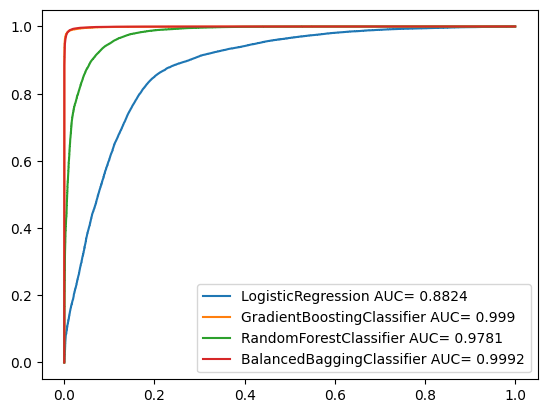

In [24]:
from sklearn import metrics
plt.figure(0).clf()
classifiers = {
    'LogisticRegression': model1,
    'GradientBoostingClassifier': model2,
    'RandomForestClassifier': model3,
    'BalancedBaggingClassifier': model4
}
for name,model in classifiers.items():
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label=f"{name} AUC= {str(auc)}")

plt.legend()
plt.savefig('/config/workspace/notebook/Images/roc_auc.jpg')
plt.show()


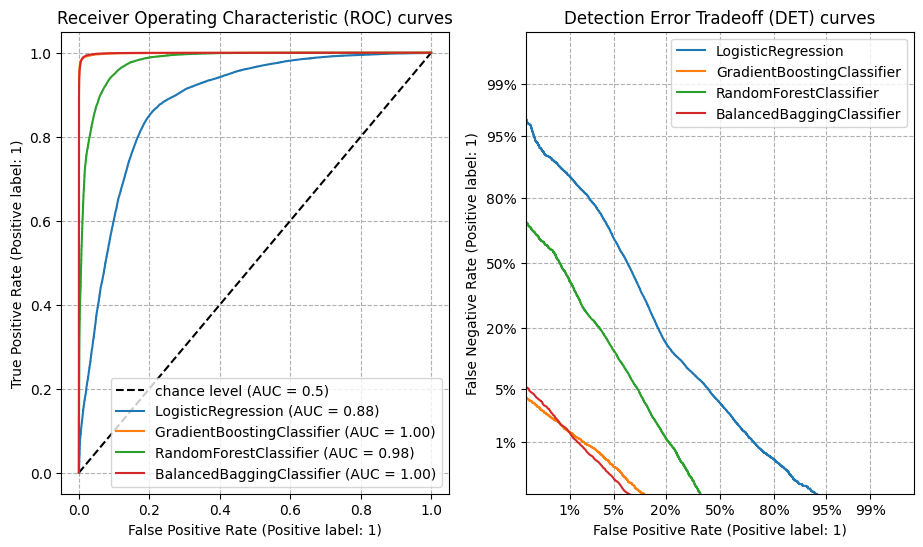

<Figure size 640x480 with 0 Axes>

In [27]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

classifiers = {
    'LogisticRegression': model1,
    'GradientBoostingClassifier': model2,
    'RandomForestClassifier': model3,
    'BalancedBaggingClassifier': model4
}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 6))
ax_roc.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

for name, clf in classifiers.items():
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)


ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()
plt.savefig('/config/workspace/notebook/Images/Detection_error_trade_off.png')

LogisticRegression f1=0.8234784794570288 auc=0.8576395933733698
GradientBoostingClassifier f1=0.9878488038009279 auc=0.9991553616602653
RandomForestClassifier f1=0.9266073899521858 auc=0.9755242327569206
BalancedBaggingClassifier f1=0.9884032364365543 auc=0.9992724066698606


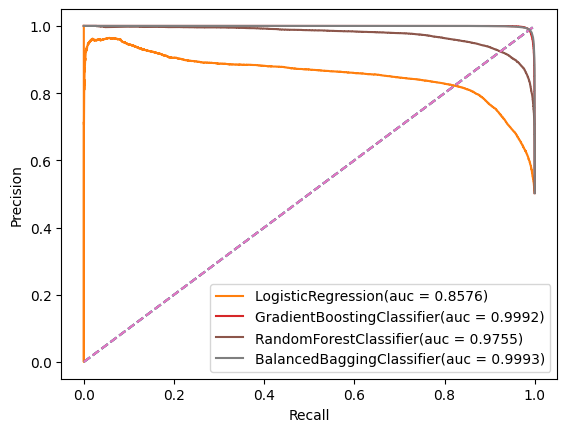

In [28]:
# precision-recall curve and f1

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

for name,model in classifiers.items():
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
  
    yhat = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, probs)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(recall, precision)
    print(f'{name} f1={lr_f1} auc={lr_auc}')

    plt.plot([0, 1], linestyle='--')
    plt.plot(recall, precision, label=f"{name}(auc = {round(lr_auc,4)})")
    # axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
    # show the legend
plt.legend()
# show the plot
plt.savefig('/config/workspace/notebook/Images/precision_recall.png')
plt.show()

### To be our model generalized we are selecting the RandomForestClassifier.